# Popular Data Science Questions
_By: Zeth De Luna &mdash; Date: August 22, 2020_

The goal of this project is to find the best topics that a data science content creator should write about. More specifically, we can translate "best" as "What is it that most people want to learn about in data science?". By answering this question, we can hopefully suggest content topics that would get the most visits.

So, what is it that most people want to learn about in data science? One way we can find out is by looking through a popular "question and answer" website about programming, called [Stack Overflow](https://stackoverflow.com/) (I know I've visited this website at least a hundred times). Stack Overflow is actually part of a much larger Q&A website called [Stack Exchange](https://stackexchange.com/), which is home to Q&A sites on a multitude of fields and subjects, including math, physics, philosophy, and more.

Since data science is a multidisciplinary field, there are several Stack Exchange websites that are relevant to our goal:
* [Data Science](https://datascience.stackexchange.com/)
* [Cross Validated](https://stats.stackexchange.com/)
* [Artificial Intelligence](https://ai.stackexchange.com/)
* [Mathematics](https://math.stackexchange.com/)
* [Stack Overflow](https://stackoverflow.com/)

A list of all the websites available on Stack Exchange is available [here](https://stackexchange.com/sites?view=list#percentanswered), ordered by the percentage of questions answered.

## Accessing the Data
Now we just need to access the data _en masse_. One way to do it is to scrape the website, which can be tedious. Luckily, Stack Exchange provides a public data base, called Stack Exchange Data Explorer ([SEDE](https://data.stackexchange.com/)), for each of its websites. If we take a look at this website, we can see that in the upper right area of the page we can compose our own queries using SQL (SEDE uses Transact-SQL &mdash; Microsoft's "version" of SQL). 

After exploring the tables available in the Data Science Stack Exchange database ([DSSE](https://data.stackexchange.com/datascience/query/new)), we found the following tables the most promising towards finding the most popular content:
* Tags
* TagSynonyms
* Posts

Let's take a look at the Posts table. This table has a lot of columns, so to make things easier we'll focus on those that seem relevant to our goal:
* `Id`: identification number for the post
* `PostTypeId`: identification number for the type of post
* `CreationDate`: date and time of creation of the post
* `Score`: the post's score
* `ViewCount`: how many times the post has been viewed
* `Tags`: what tags were used
* `AnswerCount`: how many answers the questions got (only applicable to question posts)
* `FavoriteCount`: how many times the question was favored or bookmarked (only applicable to question posts)

Let's find the types of posts and how many of each there are by creating a query in the Data Science database:

    SELECT PostTypeId, COUNT(*) as Num_of_Posts
     FROM Posts
     GROUP BY PostTypeId
     ORDER BY PostTypeId;

| PostTypeId | Num_of_Posts |
|------------|--------------|
| 1          | 25503        |
| 2          | 28231        |
| 4          | 239          |
| 5          | 239          |
| 6          | 11           |
| 7          | 1            |

And the `PostTypeId` descriptions:

    SELECT * FROM PostTypes;

| Id |        Name         |
|----|---------------------|
| 1  | Question            |
| 2  | Answer              |
| 3  | Wiki                |
| 4  | TagWikiExcerpt      |
| 5  | TagWiki             |
| 6  | ModeratorNomination |
| 7  | WikiPlaceholder     |
| 8  | PrivilegeWiki       |

Due to their low volume, anything that isn't questions or answers is mostly inconsequential. We'll just focus on the questions.

Since we're only interested in recent posts, we'll limit our analysis to the question posts of 2019 and 2020. The following query into the DSSE will extract our desired posts and columns: 

    SELECT 
      Id, 
      PostTypeId, 
      CreationDate, 
      Score, 
      ViewCount, 
      Tags, 
      AnswerCount, 
      FavoriteCount
    FROM Posts
    WHERE PostTypeId = 1 AND YEAR(CreationDate) >= 2019
    ORDER BY CreationDate ASC;
    
The resulting dataset was saved in a file called `DSSE_19_20_questions.csv`. Let's explore this dataset.

## Exploring the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import math

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
questions = pd.read_csv('DSSE_19_20_questions.csv', parse_dates=['CreationDate'])

In [3]:
questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,43363,1,2019-01-01 03:53:02,0,35,<machine-learning><nlp>,1,NaN
1,43366,1,2019-01-01 06:02:07,2,50,<deep-learning><convnet><image-classification>,1,1.0
2,43367,1,2019-01-01 06:16:26,0,24,<scikit-learn><tensorflow><scipy>,1,NaN
3,43370,1,2019-01-01 10:06:03,2,37,<classification>,0,NaN
4,43374,1,2019-01-01 13:18:02,3,37,<deep-learning><time-series><cnn><convolution>,1,NaN


In [4]:
questions.isnull().sum()

Id                   0
PostTypeId           0
CreationDate         0
Score                0
ViewCount            0
Tags                 0
AnswerCount          0
FavoriteCount    11120
dtype: int64

Quickly, we see that the `FavoriteCount` column has some missing values. Upon further investigation, we see that `FavoriteCount` has over 11,000 missing values, while the rest of the columns have no missing values. Since `FavoriteCount` represents that number of times that a post has been favorited, we can assume that a `NaN` value means that the post has not been favorited by anyone. So, to fix these missing values, we can replace all `NaN` values with `0`.

In [5]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13251 entries, 0 to 13250
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             13251 non-null  int64         
 1   PostTypeId     13251 non-null  int64         
 2   CreationDate   13251 non-null  datetime64[ns]
 3   Score          13251 non-null  int64         
 4   ViewCount      13251 non-null  int64         
 5   Tags           13251 non-null  object        
 6   AnswerCount    13251 non-null  int64         
 7   FavoriteCount  2131 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 828.3+ KB


The data types of each column seems fitting, but for sake of consistency we can convert `FavoriteCount` dtype to `int` after we replace the `NaN` values.

We also noticed that the values in the `Tags` column are lists of words separated by `< >`. To make them easier to read, we can transform the values as shown below.

Original:
`<deep-learning><convnet><image-classification>`
    
New:
`[deep-learning,convnet,image-classification]`

## Cleaning the Data

Now that we've identified the major problems with the dataset, let's fix them.

In [6]:
# replace NaN values with 0
questions['FavoriteCount'].fillna(value=0, inplace=True)

In [7]:
# convert FavoriteCount dtype to int
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

In [8]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13251 entries, 0 to 13250
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             13251 non-null  int64         
 1   PostTypeId     13251 non-null  int64         
 2   CreationDate   13251 non-null  datetime64[ns]
 3   Score          13251 non-null  int64         
 4   ViewCount      13251 non-null  int64         
 5   Tags           13251 non-null  object        
 6   AnswerCount    13251 non-null  int64         
 7   FavoriteCount  13251 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 828.3+ KB


In [9]:
# convert each Tags to a list of strings
questions['Tags'] = (questions['Tags']
                        .str.replace('^<|>$', '')
                        .str.split('><'))

In [10]:
questions.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,43363,1,2019-01-01 03:53:02,0,35,"[machine-learning, nlp]",1,0
1,43366,1,2019-01-01 06:02:07,2,50,"[deep-learning, convnet, image-classification]",1,1
2,43367,1,2019-01-01 06:16:26,0,24,"[scikit-learn, tensorflow, scipy]",1,0
3,43370,1,2019-01-01 10:06:03,2,37,[classification],0,0
4,43374,1,2019-01-01 13:18:02,3,37,"[deep-learning, time-series, cnn, convolution]",1,0


Since we already know that all of these posts are questions, `PostTypeId` is a bit redundant. So, we can just remove that column.

In [11]:
questions.drop(columns=['PostTypeId'], inplace=True)

In [12]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,43363,2019-01-01 03:53:02,0,35,"[machine-learning, nlp]",1,0
1,43366,2019-01-01 06:02:07,2,50,"[deep-learning, convnet, image-classification]",1,1
2,43367,2019-01-01 06:16:26,0,24,"[scikit-learn, tensorflow, scipy]",1,0
3,43370,2019-01-01 10:06:03,2,37,[classification],0,0
4,43374,2019-01-01 13:18:02,3,37,"[deep-learning, time-series, cnn, convolution]",1,0


The dataset looks nice and clean!

## Analyzing the Tags

Recall that our goal is to find the most popular topics in Data Science so that the content creator can focus their energy on writing about topics that will surely get views.

We can find the most popular tags by considering two differnt popularity proxies:
1. For each tag we'll count how many times the tag was used
2. We'll count how many times a question with that tag was viewed

### 1. Most Used Tags

In [13]:
# count the number of times a tag appears in the Tags column
tag_count = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
            
# convert tag_count into a dataframe            
tag_count = pd.DataFrame.from_dict(tag_count, orient='index')

In [14]:
tag_count.head()

,0
machine-learning,3941
nlp,791
deep-learning,1763
convnet,153
image-classification,322


In [15]:
tag_count.rename(columns={0:'Count'}, inplace=True)

In [16]:
tag_count.sort_values(by='Count', ascending=False, inplace=True)

In [17]:
tag_count.head(8)

,Count
machine-learning,3941
python,2702
deep-learning,1763
neural-network,1553
keras,1346
classification,1056
tensorflow,921
scikit-learn,845


We're only interested in the most popular topics, so we'll plot the top 16 most used tags.

In [18]:
tags_most_used = tag_count.head(16)

<AxesSubplot:>

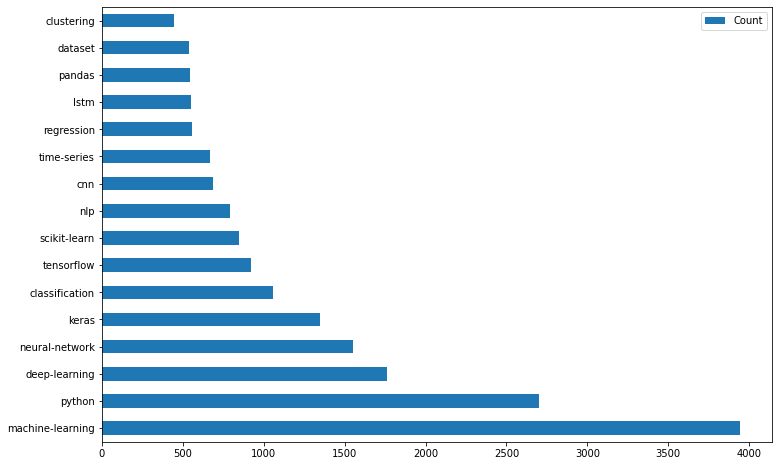

In [19]:
tags_most_used.plot(kind='barh', figsize=(12,8))

We can see from the plot that the most popular tag is `machine-learning`, followed by `python`, `deep-learning`, `neural-network`, and `keras`.

### 2. Most Viewed Tags

In [20]:
next(questions.iterrows())

(0, Id                                 43363
 CreationDate         2019-01-01 03:53:02
 Score                                  0
 ViewCount                             35
 Tags             [machine-learning, nlp]
 AnswerCount                            1
 FavoriteCount                          0
 Name: 0, dtype: object)

In [21]:
# count the number of times each tag was viewed
tag_views = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_views:
            tag_views[tag] += row['ViewCount']
        else:
            tag_views[tag] = row['ViewCount']
            
# convert tag views into a dataframe
tag_views = pd.DataFrame.from_dict(tag_views, orient='index')

Again, we only want the most popular tags, so we'll sort this dataframe by view count and choose the top 16 tags.

In [22]:
tag_views.head()

,0
machine-learning,956016
nlp,198663
deep-learning,540889
convnet,35135
image-classification,79848


In [23]:
tag_views.rename(columns={0: 'View Count'}, inplace=True)
tag_views.sort_values(by='View Count', ascending=False, inplace=True)
tags_most_viewed = tag_views.head(16)

<AxesSubplot:>

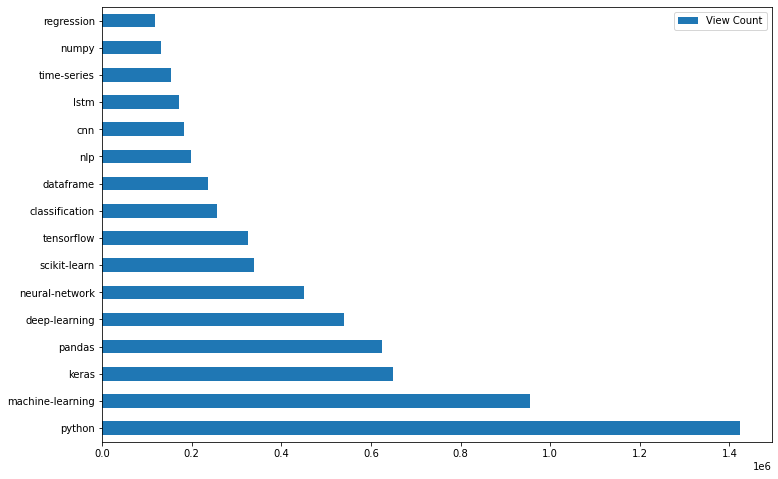

In [24]:
tags_most_viewed.plot(kind='barh', figsize=(12,8))

We see that `python` is the most viewed tag, followed by `machine-learning`, `keras`, `pandas`, and `deep-learning`.

## Comparing Most Used vs. Most Viewed
By comparing the two plots, we can see that some of the tags in the top 16 most used are the same as the tags in the top 16 most viewed. Let's find out which tags are present in both tables.

In [25]:
# Which tags_most_viewed tags are in tags_most_used?
views_in_used = pd.merge(tags_most_used, tags_most_viewed, how='left', left_index=True, right_index=True)

In [26]:
views_in_used

,Count,View Count
machine-learning,3941,956016.0
python,2702,1422844.0
deep-learning,1763,540889.0
neural-network,1553,451824.0
keras,1346,648688.0
classification,1056,257703.0
tensorflow,921,325027.0
scikit-learn,845,339775.0
nlp,791,198663.0
cnn,688,182165.0


In [27]:
# Which tags_most_used tags are in tags_most_viewed?
used_in_views = pd.merge(tags_most_viewed, tags_most_used, how='left', left_index=True, right_index=True)

In [28]:
used_in_views

,View Count,Count
python,1422844,2702.0
machine-learning,956016,3941.0
keras,648688,1346.0
pandas,624617,544.0
deep-learning,540889,1763.0
neural-network,451824,1553.0
scikit-learn,339775,845.0
tensorflow,325027,921.0
classification,257703,1056.0
dataframe,237170,NaN


Tags present in `tags_most_used` but not in `tags_most_viewed`:
* `dataset`
* `clustering`

Tags present in `tags_most_viewed` but not in `tags_most_used`:
* `dataframe`
* `numpy`

## Relationships Between Tags
For the article writers to get the most "bang for their buck", it would be best if they could write an article about a tag that is in both "most viewed" and "most used". An even better deal would be if they could write one article about multiple related tags. For example, `python` is related to `pandas` because pandas is a Python library.

Looking back at the two tables, we can see that most of the top 10 most used tags are shared with the top 10 most viewed tags. Here's what they have in common:
* `python`
* `machine-learning`
* `keras`
* `deep-learning`
* `neural-network`
* `scikit-learn`
* `tensorflow`
* `classification`

To find out if there are any strong relationships between these tags, we'll have to learn more about each tag. The [tags page](https://datascience.stackexchange.com/tags) on DSSE has descriptions of each tag.

* `python`: Use for data science questions related to the programming language Python. Not intended for general coding questions (-> stackoverflow).
* `machine-learning`: Methods and principles of building "computer systems that automatically improve with experience."
* `keras`: A minimalist, highly modular neural network library written in Python.
* `deep-learning`: A new area of Machine Learning research concerned with the technologies used for learning hierarchical representations of data, mainly done with deep neural networks (i.e. networks with two or more hidden layers), but also with some sort of Probabilistic Graphical Models.
* `neural-network`: Artificial neural networks (ANN), are composed of 'neurons' - programming constructs that mimic the properties of biological neurons. A set of weighted connections between the neurons allows information to propagate through the network to solve artificial intelligence problems without the network designer having had a model of a real system.
* `scikit-learn`: Scikit-learn is a Python module comprising of simple and efficient tool for machine learning, data mining and data analysis. It is built on NumPy, SciPy, and matplotlib.
* `tensorflow`: TensorFlow is an open source library for machine learning and machine intelligence. TensorFlow uses data flow graphs with tensors flowing along edges.
* `classification`: An instance of supervised learning that identifies the category or categories which a new instance of dataset belongs.

Based off of these definitions we were able to find that the following tags are related:
* `machine-learning` and `deep-learning`
* `machine-learning` and `scikit-learn`
* `machine-learning` and `tensorflow`
* `deep-learning` and `neural-network`
* `neural-network` and `keras`
* `python` and `keras`
* `python` and `scikit-learn`
* `python` and `classification`

To get a more solid view of the relationships, we can count how many times each pair appears together in the Tags column. There are a lot of unique tags, so we'll simplify the process by only considering the tags that are present in _both_ the top 16 most used and the top 16 most viewed.

First, we'll create a list of all tags.

In [29]:
all_tags = list(tag_count.index)

Next, we'll create a list of tags satisfying the conditions above. We'll use this list later to filter our `relationships` dataframe.

In [30]:
# find all tags that are in both Top 16 most used and most viewed
most_used_filtered = tags_most_used.drop(labels=['dataset', 'clustering'])
most_viewed_filtered = tags_most_viewed.drop(labels=['dataframe', 'numpy'])

# can use either one of the above to make the list of tags
top_tags = list(most_used_filtered.index)

Next, we'll create a dataframe where each row and each column will represent a tag.

In [31]:
relationships = pd.DataFrame(index=all_tags, columns=all_tags)

Next, we'll fill the dataframe with zeroes. Then, for each list in `questions['Tags']` we'll increment the intersecting tags by one. In the end, the dataframe will tell us how many times two tags were used together.

In [32]:
relationships.fillna(0, inplace=True)

for tags in questions['Tags']:
    relationships.loc[tags, tags] += 1

We'll filter this out since the dataframe is large and we're only interested in the most used/viewed tags. After that, we'll view the relationships using a heatmap.

In [33]:
top_relationships = relationships.loc[top_tags, top_tags]

The relationship between two identical tags will skew the heatmap and create an inaccurate visualization. To fix this, we'll replace those values with `NaN`.

In [34]:
for i in range(top_relationships.shape[0]):
    top_relationships.iloc[i, i] = np.NaN

<AxesSubplot:>

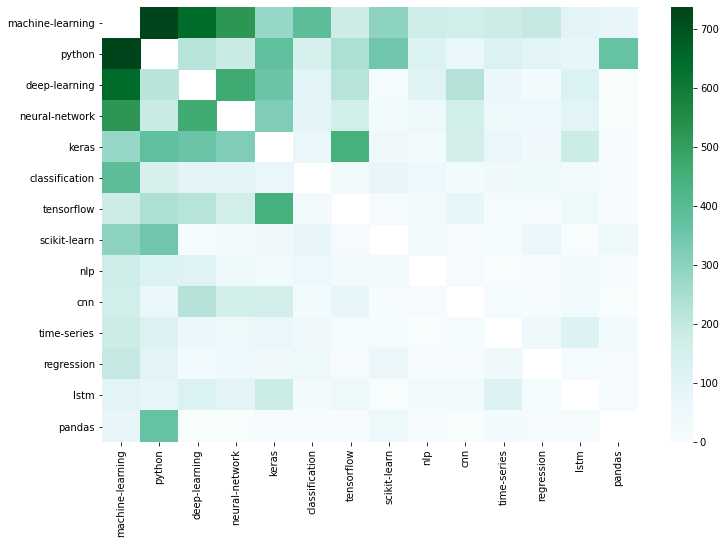

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(top_relationships, cmap='BuGn', annot=False)

From the heatmap above, we can see that `python` and `machine-learning` have the strongest relationship. `machine-learning` also has strong relationships with `deep-learning` and `neural-network`.

## Is Machine Learning Just Another Trend?
Before we make any official recommendations, we should find additional proof to confirm our findings. Machine-learning looks like it is the main tag amongst the other most popular tags. So, we'll investigate the questions posts from DSSE again to find out if the popularity of `machine-learning` has a strong follower base, or if it was just popular due to hype and will decrease in popularity quickly.

The following query obtains all of the questions on DSSE from May, 2014 to present:
    
    SELECT Id, CreationDate, Tags
    FROM Posts
    WHERE PostTypeId = 1
    ORDER BY CreationDate ASC;
    
The query results were saved into the file, `DSSE_all_questions.csv`. We'll investigate the questions to track interest in the machine learning.

In [36]:
all_questions = pd.read_csv('DSSE_all_questions.csv', parse_dates=['CreationDate'])

In [37]:
# re-format Tags items into lists
all_questions['Tags'] = (all_questions['Tags']
                            .str.replace('^<|>$', '')
                            .str.split('><'))

In [38]:
all_questions.head()

,Id,CreationDate,Tags
0,5,2014-05-13 23:58:30,[machine-learning]
1,7,2014-05-14 00:11:06,"[education, open-source]"
2,14,2014-05-14 01:25:59,"[data-mining, definitions]"
3,15,2014-05-14 01:41:23,[databases]
4,16,2014-05-14 01:57:56,"[machine-learning, bigdata, libsvm]"


Now, we'll find all questions that are about machine learning. Based off of the information from the heatmap and the [tag definitions](https://datascience.stackexchange.com/tags), we'll define a machine learning question as a question post that has the tags `machine-learning`, `classification`, `cnn`, `regression`, `scikit-learn`, and `tensorflow`. 

Even though `machine-learning` is strongly related to `deep-learning` and `neural-network` (according to the heatmap), we won't include those tags in our search to avoid including questions about deep learning and neural network.

Using our definition for a machine learning question, we'll create a new column in `all_questions`, called `MachineLearning`, that will contain `1` for rows with tags in our machine learning tag list and `0` otherwise.

In [39]:
# create list of machine learning tags
ml_tags = ['machine-learning',
           'classification',
           'cnn',
           'regression',
           'scikit-learn',
           'tensorflow']

In [40]:
# create function that finds machine learning questions
def find_machine_learning(tags):
    for tag in tags:
        if tag in ml_tags:
            return 1
        else:
            return 0
        
# apply find_machine_learning to all_questions dataframe
all_questions['MachineLearning'] = all_questions['Tags'].apply(find_machine_learning)

In [41]:
all_questions

,Id,CreationDate,Tags,MachineLearning
0,5,2014-05-13 23:58:30,[machine-learning],1
1,7,2014-05-14 00:11:06,"[education, open-source]",0
2,14,2014-05-14 01:25:59,"[data-mining, definitions]",0
3,15,2014-05-14 01:41:23,[databases],0
4,16,2014-05-14 01:57:56,"[machine-learning, bigdata, libsvm]",1
...,...,...,...,...
25599,80666,2020-08-22 18:40:09,"[keras, tensorflow]",0
25600,80667,2020-08-22 20:16:12,"[neural-network, deep-learning, time-series, c...",0
25601,80668,2020-08-22 20:38:55,"[machine-learning, regression, clustering, dat...",1
25602,80669,2020-08-22 20:51:24,"[keras, variance, gru]",0


Now that we know which questions are about machine learning (to a degree), we can count and track the activity of machine learning searches. The realm of data science isn't active enough to track on a daily, weekly, or even monthly basis. So, we'll track it quarterly.

In [42]:
quarters = (all_questions['CreationDate'].dt.year <= 2020)

all_questions = all_questions[quarters]

Now, we'll create a new column in `all_questions`, called `Quarter`, that contains which quarter of the year each question was posted.

In [43]:
# create a function that assigns a date to a quarter
def get_quarter(date):
    year = str(date.year)
    month = date.month
    quarter = str(math.ceil(month / 3))
    return '{}Q{}'.format(year, quarter)

all_questions['Quarter'] = all_questions['CreationDate'].apply(get_quarter)

Next, we'll group the dataframe by quarters, count the number of machine learning questions posted per quarter, and count the total number of questions per quarter.

In [44]:
# creates a new dataframe containing the sum of machine learning questions
# and the total number of questions, grouped by the quarters in all_questions
quarterly = all_questions.groupby('Quarter').agg({'MachineLearning': ['sum', 'size']})

# renames the columns
quarterly.columns = ['MachineLearningQuestions', 'TotalQuestions']

# find ratio of machine learning questions vs all questions
mlq = quarterly['MachineLearningQuestions']
tq = quarterly['TotalQuestions']
quarterly['MachineLearningPercentage'] = mlq / tq

# reset index to make visualization easier
quarterly.reset_index(inplace=True)

Since we only have data up until August, 2020, the `2020Q3` will be incomplete and inaccurate. So, we'll remove that row.

In [45]:
quarterly.tail(3)

,Quarter,MachineLearningQuestions,TotalQuestions,MachineLearningPercentage
23,2020Q1,840,2113,0.397539
24,2020Q2,870,2407,0.361446
25,2020Q3,453,1220,0.371311


In [46]:
quarterly.drop(labels=25, inplace=True)

Finally, we'll plot the results and see what we find.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


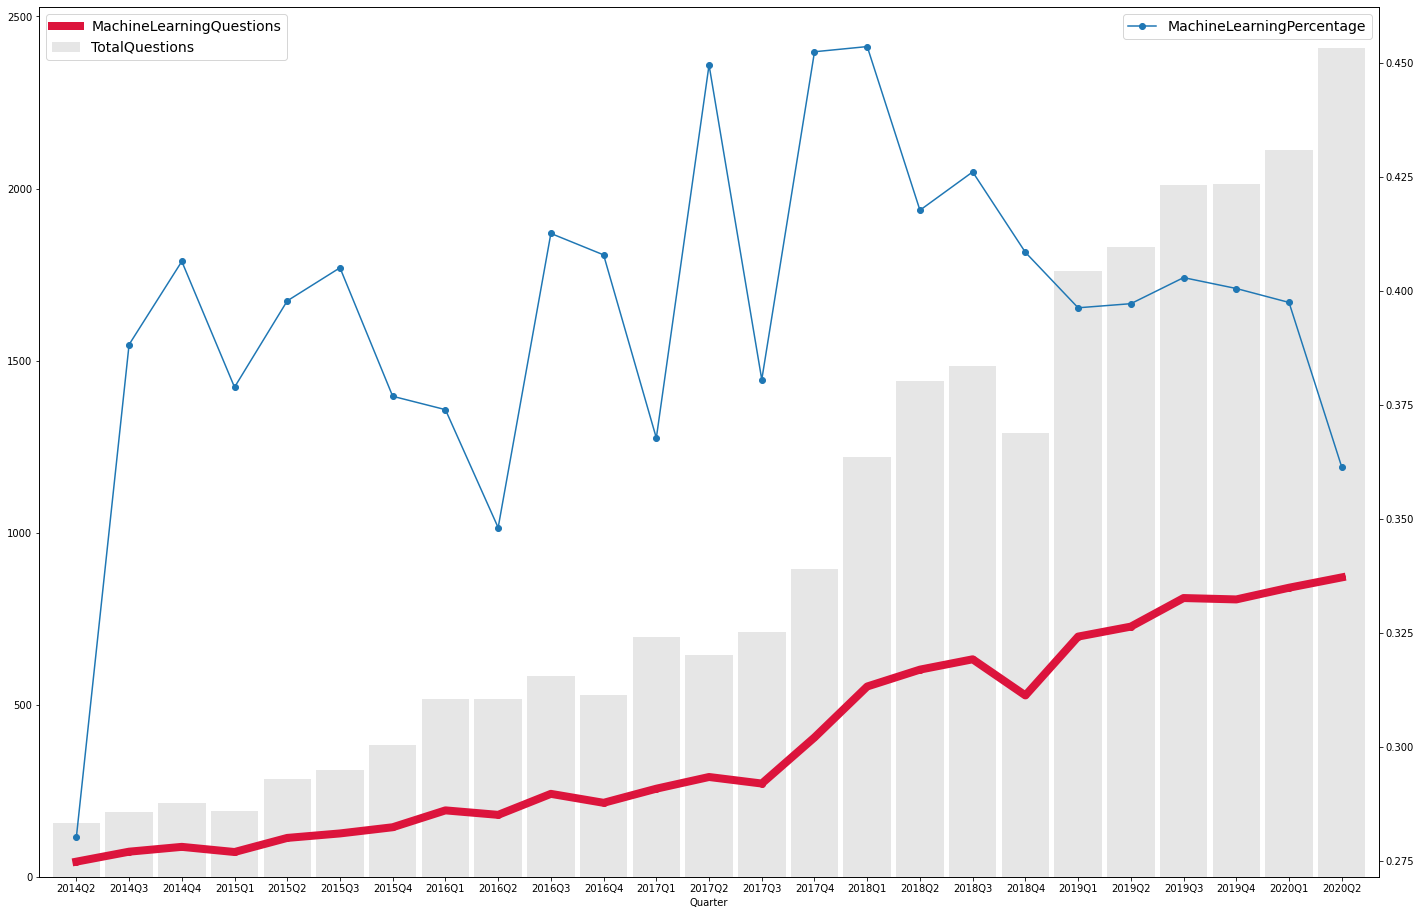

In [71]:
light_gray = (220/255 ,220/255 ,220/255)
red = (220/255, 20/255, 60/255)

ax1 = quarterly.plot(x='Quarter', y='MachineLearningQuestions',
                     kind='line', marker='o', color=red,
                     linewidth=8, figsize=(24,16))

ax2 = quarterly.plot(x='Quarter', y='TotalQuestions',
                     kind='bar', color=light_gray, ax=ax1, secondary_y=False,
                     width=0.9, alpha=0.7, rot=45)

ax3 = quarterly.plot(x='Quarter', y='MachineLearningPercentage',
                     kind='line', ax=ax1, marker='o',
                     secondary_y=True)

ax1.legend(loc='upper left', prop={'size': 14})
ax3.legend(loc='best', prop={'size': 14})

It seems that the number of machine learning questions being asked is increasing. However, the blue line indicates that in comparison with all other questions, machine learning is showing a downard trend in popularity. For this reason, I would not suggest creating machine learning content.

## Deep Learning?

Deep learning is another popular topic in the data science community, so let's see if it's worth creating deep learning content. We'll perform the same procedure as above to find out.

In [48]:
all_questions2 = pd.read_csv('DSSE_all_questions.csv', parse_dates=['CreationDate'])

all_questions2['Tags'] = (all_questions2['Tags']
                             .str.replace('^<|>$', '')
                             .str.split('><'))

In [56]:
# list of deep learning tags
dl_tags = ['deep-learning',
           'neural-network',
           'keras',
           'tensorflow',
           'scikit-learn',
           'cnn',
           'lstm']

def find_deep_learning(tags):
    for tag in tags:
        if tag in dl_tags:
            return 1
        else:
            return 0
        
all_questions2['DeepLearning'] = all_questions2['Tags'].apply(find_deep_learning)
all_questions2['Quarter'] = all_questions2['CreationDate'].apply(get_quarter)

In [57]:
all_questions2.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,5,2014-05-13 23:58:30,[machine-learning],0,2014Q2
1,7,2014-05-14 00:11:06,"[education, open-source]",0,2014Q2
2,14,2014-05-14 01:25:59,"[data-mining, definitions]",0,2014Q2
3,15,2014-05-14 01:41:23,[databases],0,2014Q2
4,16,2014-05-14 01:57:56,"[machine-learning, bigdata, libsvm]",0,2014Q2


In [64]:
dl_quarterly = all_questions2.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})

# renames the columns
dl_quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']

# find ratio of deep learning questions vs all questions
dlq = dl_quarterly['DeepLearningQuestions']
tq = dl_quarterly['TotalQuestions']
dl_quarterly['DeepLearningPercentage'] = dlq / tq

# reset index to make visualization easier
dl_quarterly.reset_index(inplace=True)
dl_quarterly.drop(labels=25, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


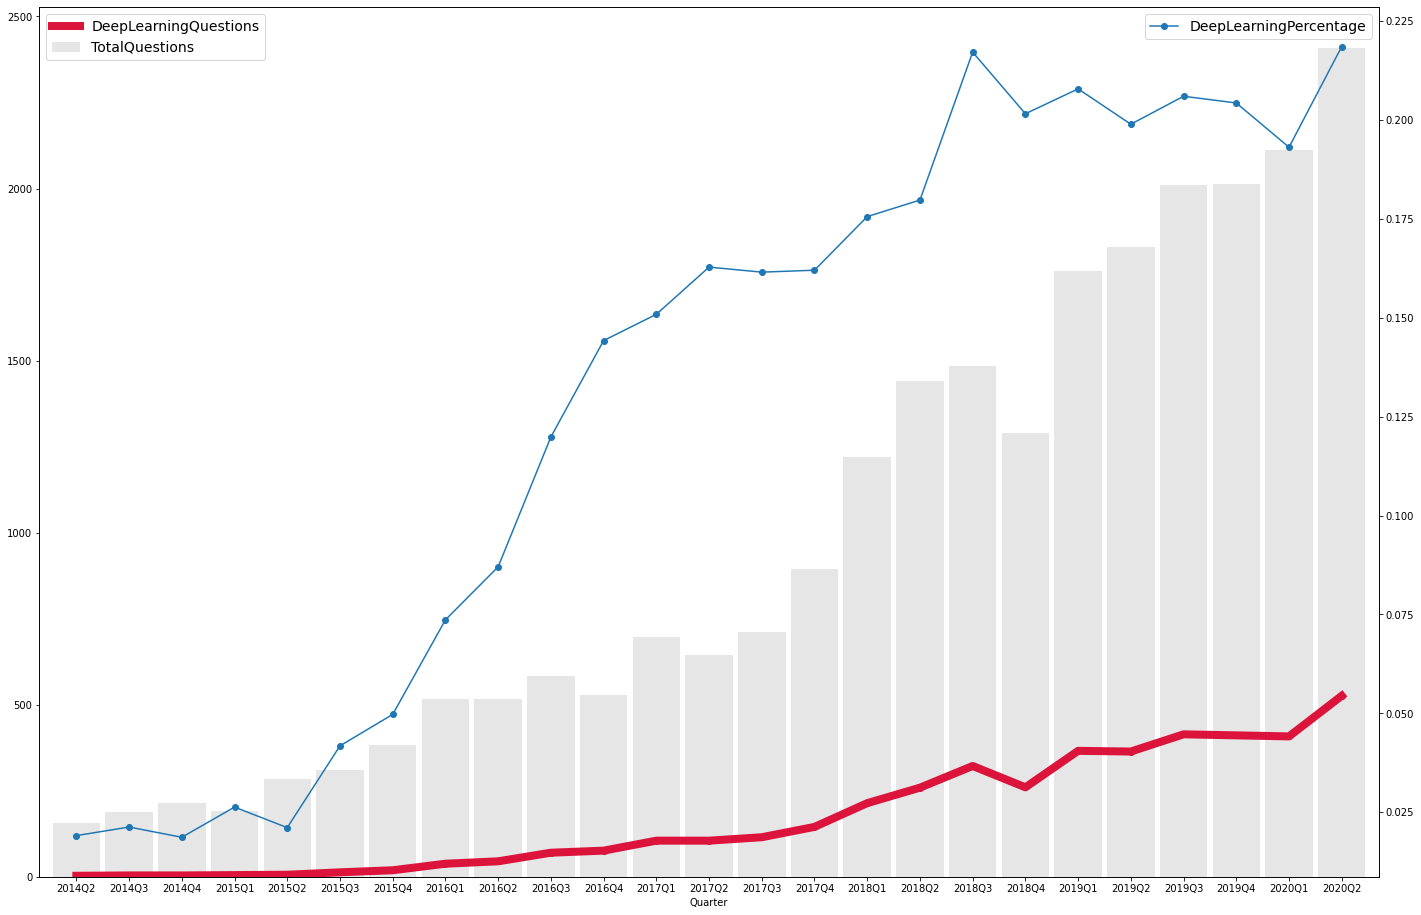

In [69]:
light_gray = (220/255 ,220/255 ,220/255)
red = (220/255, 20/255, 60/255)

ax1 = dl_quarterly.plot(x='Quarter', y='DeepLearningQuestions',
                     kind='line', marker='o', color=red,
                     linewidth=8, figsize=(24,16))

ax2 = dl_quarterly.plot(x='Quarter', y='TotalQuestions',
                     kind='bar', color=light_gray, ax=ax1, secondary_y=False,
                     width=0.9, alpha=0.7, rot=45)

ax3 = dl_quarterly.plot(x='Quarter', y='DeepLearningPercentage',
                     kind='line', ax=ax1, marker='o',
                     secondary_y=True)

ax1.legend(loc='upper left', prop={'size': 14})
ax3.legend(loc='best', prop={'size': 14})

Although the number of deep learning questions posted quarterly is less than that of machine learning, the blue line indicates that deep learning is experiencing an upward trend in popularity. So, we recommend creating deep learning content.